# Import packages

In [35]:
import pandas as pd
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import shutil
import datetime

import importlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree, erdos_renyi_graph
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import TUDataset
from torch.nn import Linear, ReLU
from torch.nn.functional import relu, softmax

# Import Data

In [36]:
num_nodes = 50
gan = "VAE_1"      # and change below True/False

colony_abr= [-17.97, -38.70]

sub_set = ""
# sub_set = "BRA_ABR_2019_02/"
# csv_files = glob.glob('Data_segmented_with_dist_reshaped/'+sub_set+str(num_nodes)+'nodes/*.csv')

oiseau = "Dactyl/"
csv_files = glob.glob("Data_segmented_completed_with_features_reshaped/*/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
# csv_files = glob.glob("Data_segmented_completed_with_features_reshaped_temps/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
main_path = gan+'/'+str(num_nodes)+"nodes/all_features/"+oiseau  # utilisé pour sauvegarder les modèles et les graphes générés
# main_path = gan+'/'+str(num_nodes)+"nodes/temp_seg/"+oiseau  # utilisé pour sauvegarder les modèles et les graphes générés

# lieu = "BRA_ABR"
# oiseau = "SDAC"
# periode = "*/"
# folder_path = "Data_segmented_GPS_reshaped/"+lieu+"/"+oiseau+"/by_dist/"  # Path to the folder where the segmented data will be stored
# csv_files = glob.glob(folder_path + '*.csv')
# main_path = "GPS_GAN/"+gan+'/'+str(num_nodes)+"nodes/"  # utilisé pour sauvegarder les modèles et les graphes générés

df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)


In [37]:
columns = ["lat", "lon"]
# "dist_to_nest", "depth"
# dist_bool = True
df_list = [df[columns] for df in df_list]

# print(df_list[0])
print("Nombre de graphes du dataset : "+str(len(df_list)))

Nombre de graphes du dataset : 152


In [38]:
# import to_graph_utils
# importlib.reload(to_graph_utils)         # pour recharger les modifications
# from to_graph_utils import *
# # df_to_graph, tensor_to_graph, df_to_graph_linked

# graph_list = [df_to_graph_linked(df) for df in df_list]
# edge_index = graph_list[0].edge_index   # le même pour tous les graphes
# for i in range(5) :   
#     print(graph_list[i])


In [39]:
# import graph_visualisation
# importlib.reload(graph_visualisation)         # pour recharger les modifications
# from graph_visualisation import *

# # for i in range(3) :   
# #     visualize_graph(graph_list[i])

# Data scaling and loader

In [40]:
# scaler = StandardScaler()
# scaled_graph_list = []
# for graph in graph_list:
#     # graph.edge_index = add_self_loops(graph.edge_index)[0]
#     scaled_features = scaler.fit_transform(graph.x)
#     scaled_features = torch.from_numpy(scaled_features).float()
#     scaled_graph_list.append(Data(x=scaled_features, edge_index=graph.edge_index))

# dataset = scaled_graph_list


# all_features = np.concatenate([graph.x.numpy() for graph in graph_list], axis=0)
all_features = np.concatenate([df for df in df_list], axis=0)
print(all_features.shape)
mean = np.mean(all_features, axis=0)
print(mean.shape)
# decalage = mean - colony_abr
# mean = mean - decalage
mean = np.array(colony_abr)
print(mean.shape)
std = np.std(all_features, axis=0)

scaled_traj_list = []
for df in df_list:
    scaled_features = (df - mean) / std
    # scaled_features = torch.from_numpy(scaled_features).float()
    # scaled_traj_list.append(Data(x=scaled_features, edge_index=graph.edge_index))
    scaled_traj_list.append(torch.from_numpy(np.array(scaled_features)).float())

dataset = scaled_traj_list

(7600, 2)
(2,)
(2,)


In [41]:
print(std)
print(mean)
# print(dataset[0])
print(dataset[0][:,0])

[0.5139976  0.41658026]
[-17.97 -38.7 ]
tensor([ 0.0195,  0.0000, -0.0195, -0.0195, -0.0195, -0.0389, -0.0389, -0.0584,
        -0.0584, -0.0584, -0.0584, -0.0584, -0.0584, -0.0778, -0.1167, -0.1167,
        -0.1556, -0.1751, -0.2140, -0.2918, -0.3697, -0.4475, -0.5058, -0.5642,
        -0.6031, -0.5837, -0.5837, -0.5837, -0.5837, -0.5837, -0.5837, -0.5642,
        -0.5253, -0.4669, -0.4475, -0.4280, -0.4086, -0.4086, -0.3891, -0.3891,
        -0.3891, -0.4086, -0.3502, -0.3307, -0.3113, -0.2335, -0.2335, -0.2140,
        -0.1946, -0.0195])


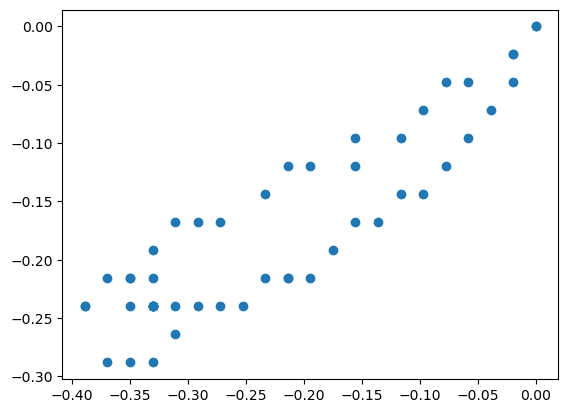

In [42]:
plt.scatter(dataset[1][:,0], dataset[1][:,1])
plt.show()
# plt.plot(dataset[1].x[:,2].numpy())   # dist_to_nest

# First correct VAE

Epoch 1, Loss: 1.3843861818313599


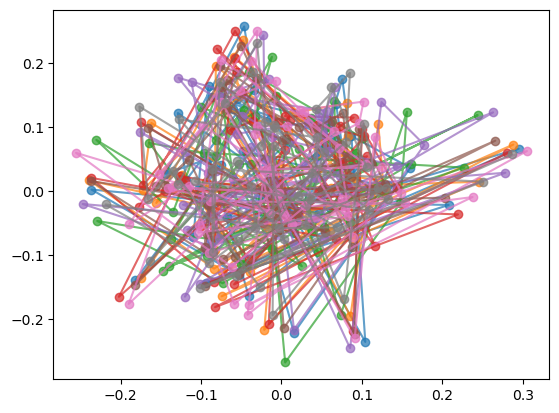

Epoch 11, Loss: 0.6481994390487671
Epoch 21, Loss: 0.21202737092971802
Epoch 31, Loss: 0.1581636667251587
Epoch 41, Loss: 0.1777874231338501
Epoch 51, Loss: 0.2988682985305786


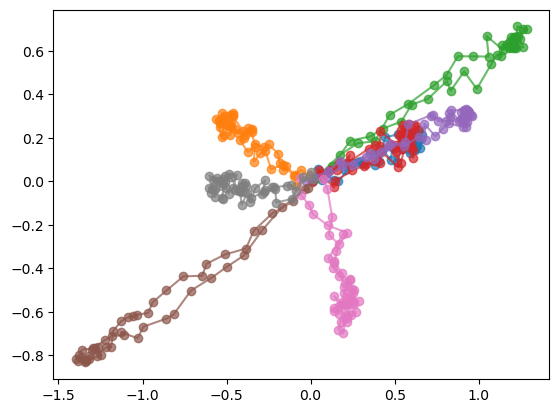

Epoch 61, Loss: 0.3112010955810547
Epoch 71, Loss: 0.15016916394233704
Epoch 81, Loss: 0.3314913213253021
Epoch 91, Loss: 0.41626566648483276
Epoch 101, Loss: 0.2743287682533264


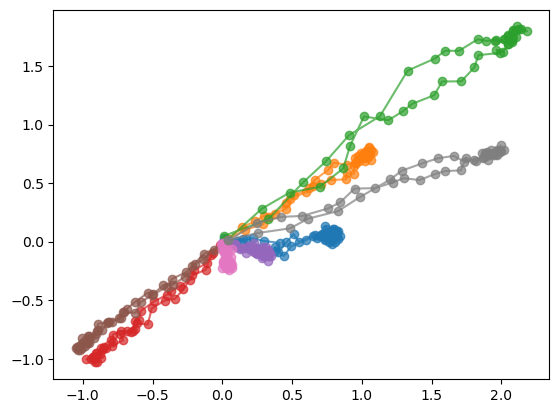

Epoch 111, Loss: 0.33686965703964233
Epoch 121, Loss: 0.44522231817245483
Epoch 131, Loss: 0.44466689229011536
Epoch 141, Loss: 0.4761296510696411
Epoch 151, Loss: 0.4575001299381256


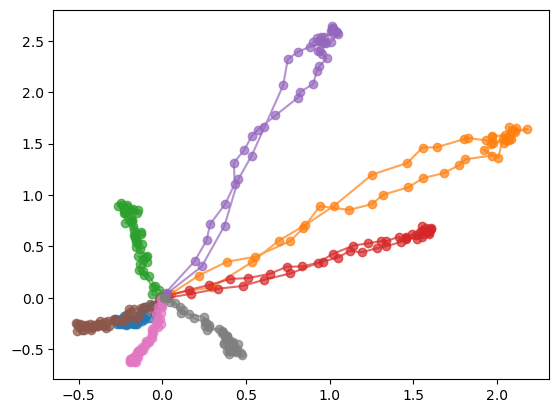

Epoch 161, Loss: 0.4493587911128998
Epoch 171, Loss: 0.4520920515060425
Epoch 181, Loss: 0.37691789865493774
Epoch 191, Loss: 0.4807971715927124
Epoch 201, Loss: 0.3653438687324524


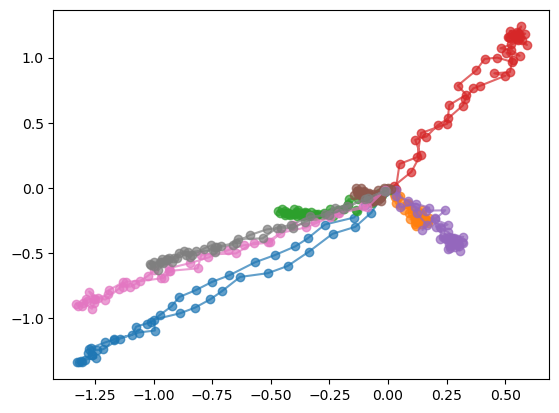

Epoch 211, Loss: 0.4547673165798187
Epoch 221, Loss: 0.6764569282531738
Epoch 231, Loss: 0.4197215139865875
Epoch 241, Loss: 0.4350128173828125
Epoch 251, Loss: 0.38216477632522583


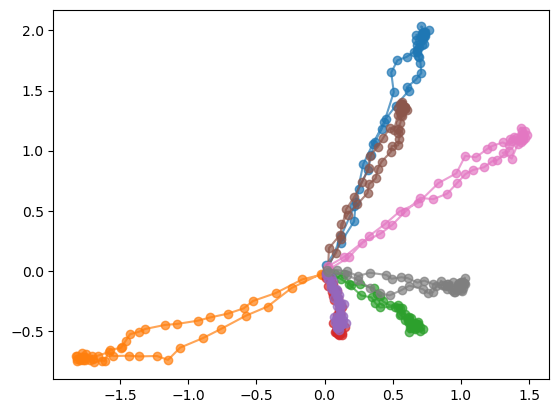

Epoch 261, Loss: 0.7031031250953674
Epoch 271, Loss: 0.5068091750144958
Epoch 281, Loss: 0.36528438329696655
Epoch 291, Loss: 0.5000216960906982
Epoch 301, Loss: 0.6351876258850098


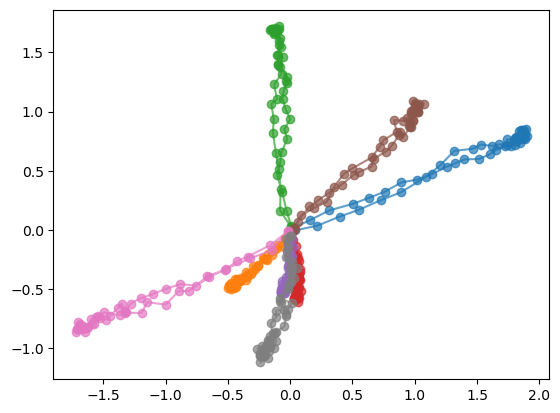

Epoch 311, Loss: 0.5104337930679321
Epoch 321, Loss: 0.5494838953018188
Epoch 331, Loss: 0.3785121738910675
Epoch 341, Loss: 0.4344002604484558
Epoch 351, Loss: 0.3548979163169861


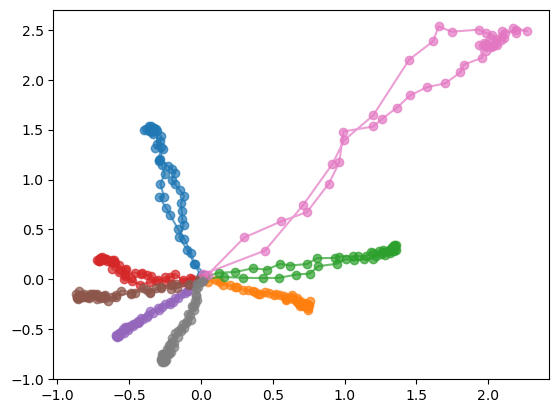

Epoch 361, Loss: 0.30108505487442017
Epoch 371, Loss: 0.4985128939151764
Epoch 381, Loss: 0.4669206142425537
Epoch 391, Loss: 0.4369502067565918
Epoch 401, Loss: 0.6418570280075073


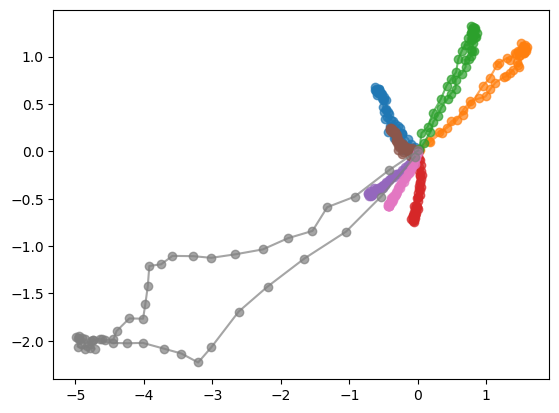

Epoch 411, Loss: 0.4268217086791992
Epoch 421, Loss: 0.3900572657585144
Epoch 431, Loss: 0.3215668797492981
Epoch 441, Loss: 0.3902623951435089
Epoch 451, Loss: 0.4694503843784332


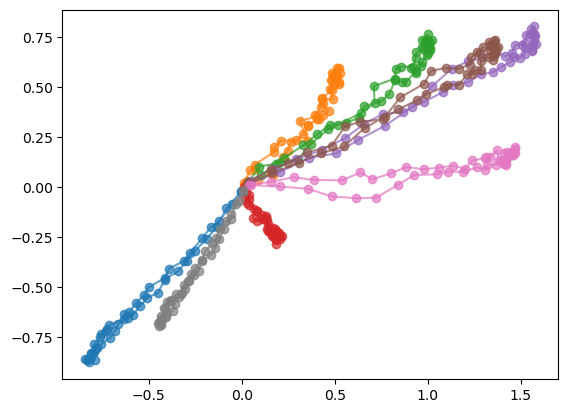

Epoch 461, Loss: 0.5193642377853394


KeyboardInterrupt: 

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(50 * 2, hidden_dim*2),  # 50 steps, 2 dims (lat, lon)
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),  # decoder input dimension is latent_dim
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, 50 * 2)  # 50 steps, 2 dims (lat, lon)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mean(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        return self.decode(z)

# Initialize the VAE model
vae = VAE(input_dim=2, latent_dim=10, hidden_dim=16)

# # Define the loss function and optimizer
# def loss_function(recon_x, x, mu, logvar):
#     BCE = torch.nn.functional.mse_loss(recon_x, x)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# def mmd_loss(samples1, samples2):
#     # Calculate the squared distance matrix between the two sets of samples
#     dists = ((samples1[:, None, :] - samples2[None, :, :]) ** 2).sum(2)
#     # Calculate the MMD term as the maximum of the mean of the squared distances
#     # between all pairs of samples from the two sets
#     mmd = torch.max(dists.mean(0), dists.mean(1))
#     return mmd

# def loss_function(recon_x, x, mu, logvar, generated_samples):
#     BCE = torch.nn.functional.mse_loss(recon_x, x)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     MMD = mmd_loss(generated_samples, x)
#     return BCE + KLD + MMD

def loss_function(recon_x, x, mu, logvar, epoch, total_epochs, kl_weight_max=0.02):
    BCE = torch.nn.functional.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KL divergence schedule
    kl_weight = min(kl_weight_max, 1 * (epoch / total_epochs) ** 2 )   
    return BCE + kl_weight * KLD


optimizer = optim.Adam(vae.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


def visualize_trajectories(vae, num_trajectories):
    """Visualize a set of random trajectories generated by the VAE."""
    vae.eval()
    with torch.no_grad():
        trajectories = vae.sample(num_trajectories)
    trajectories = trajectories.cpu().detach().numpy()
    trajectories = trajectories.reshape(num_trajectories, 50, 2)
    for i in range(num_trajectories):
        plt.plot(trajectories[i][:, 0], trajectories[i][:, 1], '-o', alpha=0.7)
    plt.show()

# Train the VAE
num_epochs = 1000
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        batch = batch.reshape(-1, 50*2)
        recon_batch, mu, logvar = vae(batch)
        # loss = reconstruction_loss(recon_batch, batch) + kl_divergence(logvar, torch.zeros_like(logvar))
        # loss = loss_function(recon_batch, batch, mu, logvar)
        # generated_samples = vae.sample(batch.size(0))  # Generate samples from the VAE model
        # loss = loss_function(recon_batch, batch, mu, logvar, generated_samples)
        loss = loss_function(recon_batch, batch, mu, logvar, epoch=epoch, total_epochs=1000)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    if epoch % 50 == 0:
        visualize_trajectories(vae, 8)

# # Modify the train function to include visualization
# def train(vae, dataloader, device, num_epochs):
#     """Train the VAE and visualize generated trajectories after each epoch."""
#     optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
#     for epoch in range(num_epochs):
#         for batch in dataloader:
#             optimizer.zero_grad()
#             recon_batch, mu, logvar = vae(batch)
#             loss = vae.loss_function(recon_batch, batch, mu, logvar)
#             loss.backward()
#             optimizer.step()
#         if epoch % 10 == 0:
#             print(f"Epoch {epoch+1}, Loss: {loss.item()}")
#         visualize_trajectories(vae, 25, device)

# Tools test

In [ ]:
import tools
importlib.reload(tools)         # pour recharger les modifications
from tools import *

num_trajectories = len(df_list)
vae.eval()
with torch.no_grad():
    trajectories = vae.sample(num_trajectories)
trajectories = trajectories.cpu().detach().numpy()
trajectories = trajectories.reshape(num_trajectories, num_nodes, 2)

generated_traj = [trajectory for trajectory in trajectories]

for i in range(len(generated_traj)) :
    generated_traj[i] = generated_traj[i]
    generated_traj[i][:, :] = generated_traj[i][:, :] - generated_traj[i][0, :]
    generated_traj[i] = generated_traj[i] * std + mean

    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_step_length(generated_traj[i]), axis=1) ), axis=1)
    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_dist_nest(colony_abr, generated_traj[i]), axis=1) ), axis=1)

print(len(df_list))
print(len(generated_traj))
print(generated_traj[0].shape)

df_reals = [df.to_numpy() for df in df_list]
print(df_reals[0].shape)
for i in range(len(df_list)):
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_step_length(df_reals[i]), axis=1) ), axis=1)
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_dist_nest(colony_abr, df_reals[i]), axis=1) ), axis=1)

dist_max_gen = np.array([get_max_dist_nest(colony_abr, generated_traj[i]) for i in range(len(generated_traj))])
total_dist_gen = np.array([total_distance(generated_traj[i]) for i in range(len(generated_traj))])
dist_max_real = np.array([get_max_dist_nest(colony_abr, df_list[i].to_numpy()) for i in range(len(df_list))])
total_dist_real = np.array([total_distance(df_list[i].to_numpy()) for i in range(len(df_list))])
all_distances = dist_max_real + dist_max_gen
min_distance = min(min(dist_max_real), min(dist_max_gen))
max_distance = max(max(dist_max_real), max(dist_max_gen))
all_total = total_dist_real + total_dist_gen
min_total = min(min(total_dist_real), min(total_dist_gen))
max_total = max(max(total_dist_real), max(total_dist_gen))



152
152
(50, 4)
(50, 2)


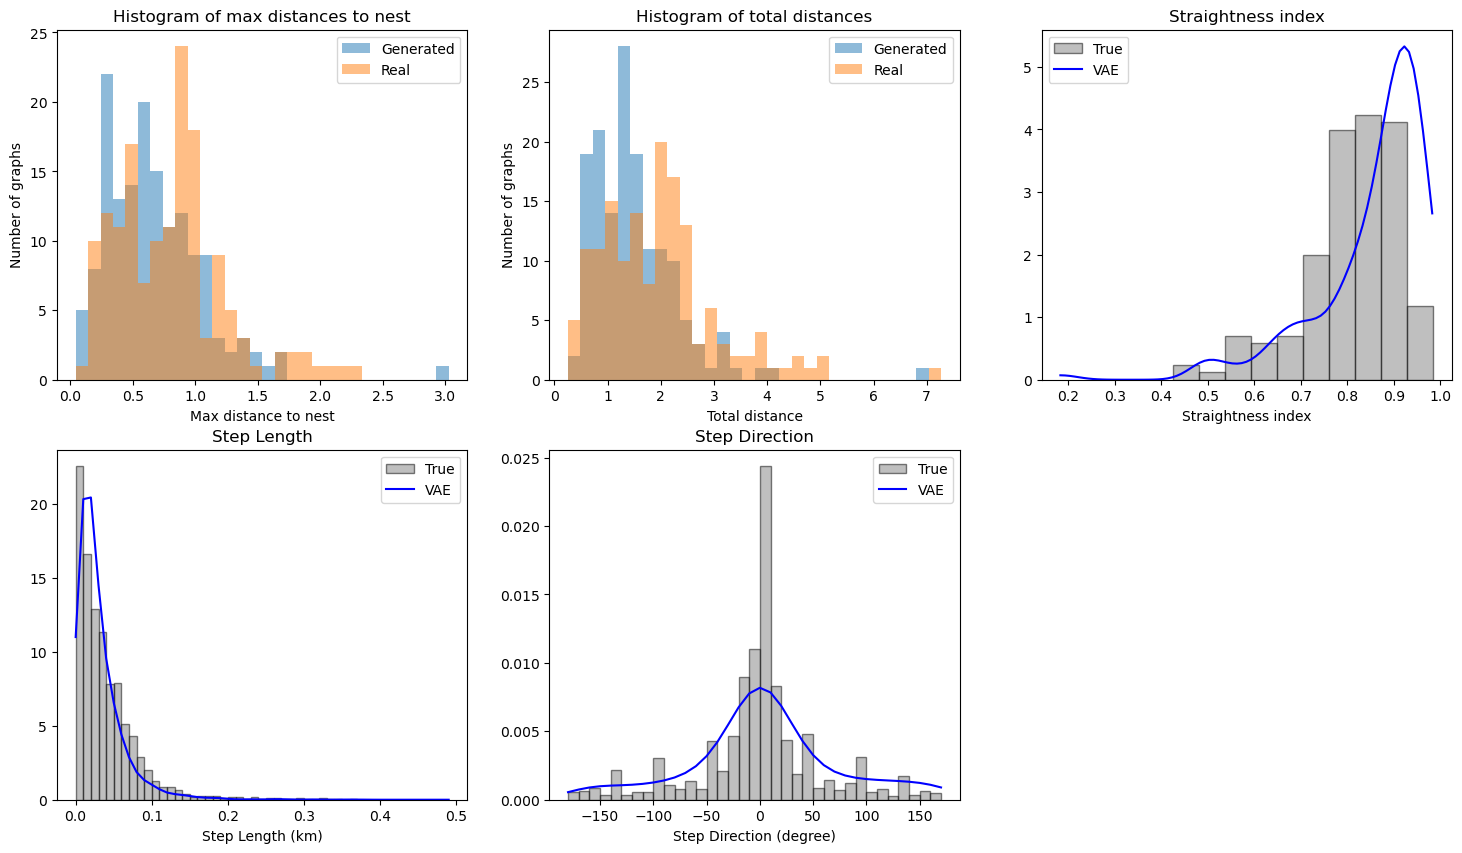

In [ ]:
plt.figure(figsize=(18, 10))


# print histogramme des distances max des générées et des réelles
plt.subplot(2, 3, 1)
plt.hist(dist_max_gen, bins=30, alpha=0.5, label='Generated', range=(min_distance, max_distance))
plt.hist(dist_max_real, bins=30, alpha=0.5, label='Real', range=(min_distance, max_distance))
plt.legend(loc='upper right')
plt.xlabel("Max distance to nest")
plt.ylabel("Number of graphs")
plt.title("Histogram of max distances to nest")

# print histogramme des distances totales des générées et des réelles
plt.subplot(2, 3, 2)
plt.hist(total_dist_gen, bins=30, alpha=0.5, label='Generated', range=(min_total, max_total))
plt.hist(total_dist_real, bins=30, alpha=0.5, label='Real', range=(min_total, max_total))
plt.legend(loc='upper right')
plt.xlabel("Total distance")
plt.ylabel("Number of graphs")
plt.title("Histogram of total distances")


# STRAIGHTNESS INDEX
plt.subplot(2, 3, 3)
# Plus la valeur est proche de 1, plus le trajet est rectiligne
y = [get_trip_sinuosity(df) for df in df_reals]
y_1 = [get_trip_sinuosity(traj) for traj in generated_traj]
# y_3 = get_trip_sinuosity(data_fake_3)
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3, bw = 0.3)

x = np.arange(min(min(y),min(y_1)), max(max(y),max(y_1)), 0.01)
plt.hist(y, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'VAE')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.xlabel("Straightness index")
plt.title('Straightness index')
plt.legend()


# STEP LENGTH
plt.subplot(2, 3, 4)
y_1 = np.concatenate([traj[:,2] for traj in generated_traj])
# y_3 = data_fake_3.step_distance/1e3
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(0,0.5, 0.01)
plt.hist(np.concatenate([df[:,2] for df in df_reals]), color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True, bins = x)
plt.plot(x, dy_1(x), color = 'blue', label = 'VAE')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.xlabel("Step Length (km)")
plt.title('Step Length')
plt.legend()


# STEP DIRECTION
plt.subplot(2, 3, 5)
c_fake = np.concatenate( [cap( traj[0:(num_nodes-1), 1], traj[0:(num_nodes-1), 0], traj[1:, 1], traj[1:, 0]) for traj in generated_traj] )
direction_fake = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_fake)]

c_real = np.concatenate( [cap( df[0:(num_nodes-1), 1], df[0:(num_nodes-1), 0], df[1:, 1], df[1:, 0]) for df in df_reals] )
direction_real = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_real)]

y_1 = direction_fake
# y_3 = data_fake_3.step_direction
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(direction_real, bins = x, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'VAE')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.xlabel("Step Direction (degree)")
plt.title('Step Direction')
plt.legend()



# # Save the hyperparameters to a text file
# figure_path = folder_path_date + "stats_descriptives.png"
# plt.savefig(figure_path)

# Visualisation on a map

In [ ]:
import graph_visualisation
importlib.reload(graph_visualisation)         # pour recharger les modifications
from graph_visualisation import *

In [ ]:
df_generated = [pd.DataFrame(trajectory, columns=columns) for trajectory in trajectories]

for i in range(len(df_generated)):
    df_generated[i].iloc[:, :] = df_generated[i].iloc[:, :] - df_generated[i].iloc[0, :]
    df_generated[i] = df_generated[i]*std + mean

# colony = df_generated[0][["lat","lon"]].iloc[0]
# colony_abr= [-17.97, -38.70]

plot_map(df_generated, colony_abr)
plot_map(df_list, colony_abr)